In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [41]:
df = pd.read_csv('train.csv',nrows = 10_000_000)
test_df = pd.read_csv('test.csv')

In [42]:
df.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    69
dropoff_latitude     69
passenger_count       0
dtype: int64

In [43]:
test_df.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

### Dropped rows with null values

In [5]:
df.dropna(subset=['dropoff_latitude', 'dropoff_longitude'], inplace = True)

In [6]:
df.shape

(9999931, 8)

### Dropped latitude and longitude values which did not belong to the state of New York

- Googled the range of values for latitude and longitude of New York
- Latitude range: 41 to 45
- Longitude range: -78 to -71

In [44]:
# df = df[df.pickup_longitude > -179]
# df = df[df.dropoff_longitude > -179]
# df = df[df.pickup_longitude < 181]
# df = df[df.dropoff_longitude < 181]
# df = df[df.pickup_latitude > -89]
# df = df[df.dropoff_latitude > -89]
# df = df[df.pickup_latitude < 91]
# df = df[df.dropoff_latitude < 91]

df = df[df.pickup_longitude > -79]
df = df[df.dropoff_longitude > -79]
df = df[df.pickup_longitude < -72]
df = df[df.dropoff_longitude < -72]
df = df[df.pickup_latitude > 40]
df = df[df.dropoff_latitude > 40]
df = df[df.pickup_latitude < 46]
df = df[df.dropoff_latitude < 46]

In [45]:
df.shape

(9790043, 8)

### Deleted rows with passenger count greater than 6

In [46]:
#df = df[2.5 < df.fare_amount]
#df = df[500 > df.fare_amount]
df = df[7 > df.passenger_count]
df = df[df.passenger_count > 0]

In [47]:
df.shape

(9755513, 8)

### Decomposed the date and time column to year, month, date, day and hour

In [48]:
df['key'] = pd.to_datetime(df['key'])
key = test_df.key
test_df['key'] = pd.to_datetime(df['key'])
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])

In [49]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['date'] = df['pickup_datetime'].dt.day
df['day'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour
df = df.drop('pickup_datetime', axis=1)
df = df.drop('key',axis=1)

In [50]:
test_df['year'] = test_df['pickup_datetime'].dt.year
test_df['month'] = test_df['pickup_datetime'].dt.month
test_df['date'] = test_df['pickup_datetime'].dt.day
test_df['day'] = test_df['pickup_datetime'].dt.dayofweek
test_df['hour'] = test_df['pickup_datetime'].dt.hour
test_df = test_df.drop('pickup_datetime', axis=1)
test_df = test_df.drop('key',axis=1)

In [51]:
df.shape

(9755513, 11)

### Added a new column distance which was calculated using the Haversine formula

In [52]:
diff_long = df['dropoff_longitude'] - df['pickup_longitude']
diff_lat = df['dropoff_latitude'] - df['pickup_latitude']
var = np.sin(diff_lat/2)**2 + np.cos(df['pickup_latitude']) * np.cos(df['dropoff_latitude']) * np.sin(diff_long/2)**2
c = 2 * np.arcsin(np.sqrt(var))
r = 6371
df['distance'] = c*r

In [53]:
diff_long2 = test_df['dropoff_longitude'] - test_df['pickup_longitude']
diff_lat2 = test_df['dropoff_latitude'] - test_df['pickup_latitude']
var2 = np.sin(diff_lat2/2)**2 + np.cos(test_df['pickup_latitude']) * np.cos(test_df['dropoff_latitude']) * np.sin(diff_long2/2)**2
c2 = 2 * np.arcsin(np.sqrt(var2))
r = 6371
test_df['distance'] = c2*r

In [31]:
df.shape

(9964095, 12)

In [1]:
from IPython import display

### Split the dataset into train and validation set

In [54]:
y = df['fare_amount']
X = df.drop('fare_amount',axis=1)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

### Applied the Random Forest Regressor on the train dataset

In [55]:
model_rf = RandomForestRegressor(max_depth = 10,n_estimators=10)
model_rf.fit(X_train,y_train)
score = model_rf.score(X_val,y_val)
score 

0.8358180536819508

### RMSE score of Random Forest Regressor on the validation set

In [56]:
val_preds = model_rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val,val_preds))
rmse

3.9232874950820014

In [57]:
preds = model_rf.predict(test_df)
preds

array([10.04355088, 10.83504672,  5.02911027, ..., 55.55798503,
       21.64489791,  7.63593048])

In [58]:
submission = pd.DataFrame(
    {'key': key, 'fare_amount': preds},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)

### RMSE score on kaggle for Random Forest Regressor

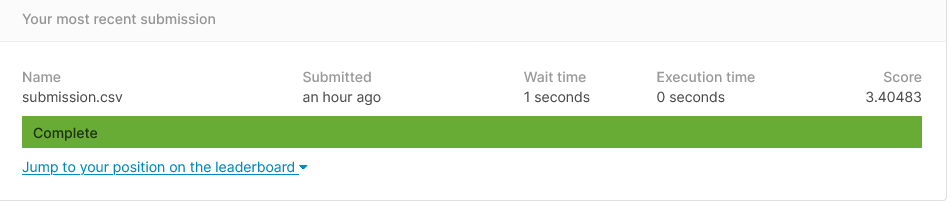

In [2]:
display.Image('RFR.png')

### Using the XGBoost regressor on the train dataset

In [59]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(test_df)

xgb_params = {
    'eta': 1,
    'objective':'reg:linear',
    'learning_rate': 0.05,  
    'max_depth': 7,
    'silent': 1,
    'eval_metric': 'rmse'}

model = xgb.train(xgb_params, dtrain, 50)

[15:00:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [61]:
dtest = xgb.DMatrix(test_df)
test_preds = model.predict(dtest)

### RMSE score of XGBoost regressor on the validation set

In [60]:
val = xgb.DMatrix(X_val)
preds2 = model.predict(val)
rmse = np.sqrt(mean_squared_error(y_val,preds2))
rmse

4.283797847881697

In [39]:
len(preds2)

1992819

In [62]:
submission = pd.DataFrame(
    {'key': key, 'fare_amount': test_preds},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission2.csv', index = False)

### RMSE score on kaggle for XGBoost Regressor

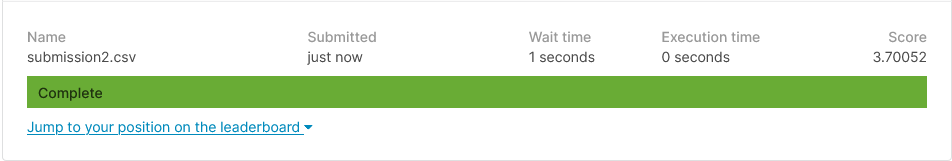

In [3]:
display.Image('XGB.png')